# Meeting notes

- Take hists at both ends, see if spc peak moves
- Uncertainty in height - should be fairly low - counting uncertainty along arc (sqrtN). Total signal matters in regions of low signal - stochastic processes vs something real.
    - Relationship b/w intensities at different energies is important
    - Explain why we do/dont need to do stuff

- Out on wings, do we have enough data (probably yes - smooth curve)

- SNR - height of spectrum vs uncertainty
    - If we can calculate SNR for a spectrum, we can then use gradient descent etc to optimise parameters to minimise SNR.
    - -> how do our decisions affect outcome? Computer can optimise these parameters.



Submit draft by end of W9


# Seeing how SPC is working now

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from histograms import make_histogram

img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2)

bin_centres, hist = make_histogram(spc.all_hit_values, -1)

(0.0, 300.0)

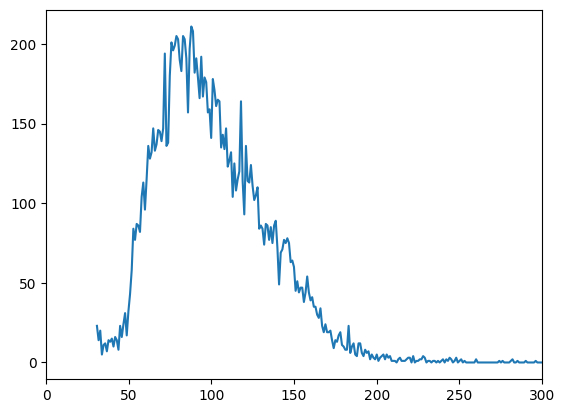

In [2]:
plt.plot(bin_centres, hist)
plt.xlim(0, 300)

## Poisson stats

To check that we're doing the SPC correctly, we should consider more accurate poisson statistics. Poisson statistics should only be valid for a area that has roughy constant probability of photon hits, so let's write a function to get the histogram/photon statistics for a given energy range

In [20]:
from spc import SPC


def hits_in_energy_band(hit_locs, E_min, E_max, k, D, centre):
    min_r = D / k * np.sqrt(E_min**2 - k**2)
    max_r = D / k * np.sqrt(E_max**2 - k**2)

    radii = np.sqrt(
        (hit_locs[:, 0] - centre[1]) ** 2 + (hit_locs[:, 1] - centre[0]) ** 2
    )

    hits_in_band = hit_locs[np.logical_and((radii > min_r), (radii < max_r))]

    return hits_in_band

In [5]:
from spc import SPC
from bragg import EnergyMap

spc = SPC(img, 75, 30, 2)
energies = [1218.5, 1188.0]
energy_map = EnergyMap(spc.img, 5, 200, 20, 2, 100, (25, 25), energies)

(10, 500)

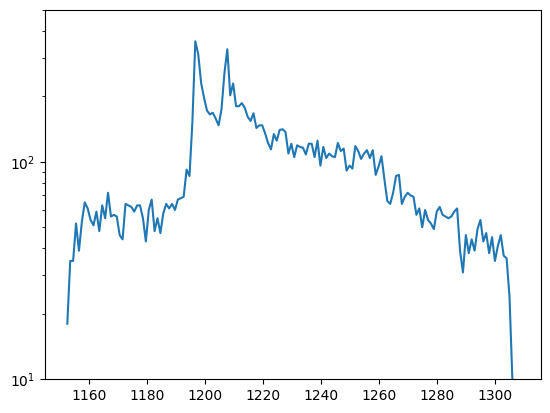

In [7]:
spectrum = energy_map.get_energies(spc.all_hit_locations)

bin_centres, hist = make_histogram(spectrum, -1)

plt.plot(bin_centres, hist)
plt.yscale("log")
plt.ylim(10, 500)

In [35]:
off_peak_hits = hits_in_energy_band(
    spc.all_hit_locations,
    1240,
    1280,
    energy_map.k,
    energy_map.D,
    energy_map.centre,
)
N_pixels = len(hits_in_energy_band(
    np.indices(spc.img.shape).reshape(2, -1).T,
    1240,
    1280,
    energy_map.k,
    energy_map.D,
    energy_map.centre,
))



double_hit_pixels = spc.count_double_hits(off_peak_hits)
single_hit_pixels = len(off_peak_hits) - 2*double_hit_pixels

print(single_hit_pixels/double_hit_pixels)
print(2*N_pixels/(single_hit_pixels + 2*double_hit_pixels))



23.522058823529413
624.0674157303371


So, we are still seeing too many doubles - this needs to be fixed. Let's try identifying all doubles in an image, and looking at the ones that are incorrect

TODO: #1 Fix double hit detection

# Energy map

Currently, there is a calibration issue with the energy map. We can modify our fitting, in order to force the peaks into the right place

In [1]:
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram
import numpy as np
import matplotlib.pyplot as plt

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2)

In [2]:

energies = [1218.5, 1188.0]

energy_map = EnergyMap(spc.img, 5, 200, 20, 2, 100, (25, 25), energies)
spectrum = energy_map.get_energies(spc.all_hit_locations)
energy_map.calibrate_energies(spectrum)

new_spectrum = energy_map.get_energies(spc.all_hit_locations)

bin_centres, hist = make_histogram(spectrum, -1)
new_bin_centres, new_hist = make_histogram(new_spectrum, -1)


9448.859206475745 9636.599755650424
8885.835577766336 8899.902557342044


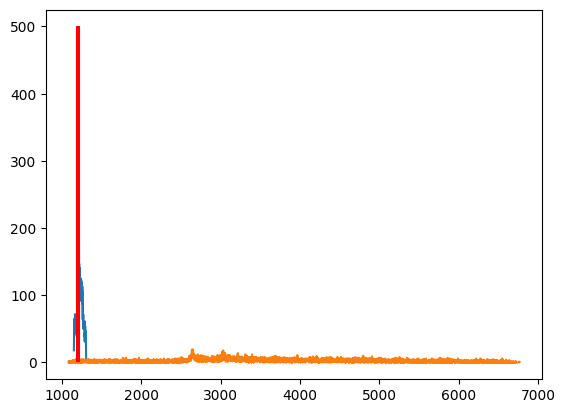

In [3]:
plt.plot(bin_centres, hist)
plt.plot(new_bin_centres, new_hist)

plt.vlines(energies, 0, 500, colors="r")
plt.show()

In [4]:
energy_map.A, energy_map.B

(29.499575091128193, -252790.65969889815)

Looks like it's better to re-calculate the locations of the peaks using `scipy`, to make sure we get the locations absolutely correct